# Iterative use of Cleanlab to Improve Classification Models (and Consensus Labels) from Data Labeled by Multiple Annotators

This example shows how to repeatedly improve consensus labels established from data labeled by multiple annotators by iterating the following steps: (1) train a model on the current consensus labels, (2) leverage the model's predictions to obtain superior consensus labels that can be used to subsequently train a better model in the next round. In each round, consensus labels are established using the [CROWDLAB algorithm](TODO:linktopaper), for which a quickstart tutorial is available in the [cleanlab documentation](https://docs.cleanlab.ai/). 

Here we demonstrate this functionality using a subset of the [CIFAR-10H](https://github.com/jcpeterson/cifar-10h) dataset from Peterson et al. (2019), in which multiple human annotators were asked to suggest labels for images from the famous [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image classification dataset.
Because this notebook utilizes AutoML for model training and cleanlab is compatible with any model/dataset, you should be able to run the below code with any image classification dataset where each image has been labeled by multiple annotators.

## Import required dependencies and download data

In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime

from utils.model_training import train_model, sum_xval_folds
from cleanlab.multiannotator import get_majority_vote_label, get_label_quality_multiannotator

In [ ]:
experiment_path = "./experiment"  # folder to save outputs from this notebook
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
    print("Directory " , experiment_path ,  " Created ")
else:    
    print("Directory " , experiment_path ,  " already exists")

print(f'Experiment saved in {experiment_path}')

In [ ]:
# Download CIFAR-10 dataset for model training (requires internet connection)
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10/cifar10_test.tar.gz'
!tar -xzf cifar10_test.tar.gz

# Here is an alternative command to download the data from the source:
# cifar2png cifar10 ./data/cifar10_test --name-with-batch-index

# Import CIFAR-10h labels and image paths
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_labels_worst25_coin20.npy'
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_image_paths.npy'
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_test_labels.npy'

## Load labels selected by each annotator
Here `multiannotator_labels` is a subset of `CIFAR-10H`, where each image has been labeled by one or more annotators, but not every annotator has labeled every image.

In [4]:
# Load labels
multiannotator_labels = np.load(f'{experiment_path}/c10h_labels_worst25_coin20.npy')

# Load and reformat image paths to work for specific machine
image_paths = np.load(f'{experiment_path}/c10h_image_paths.npy', allow_pickle=True)
path = os.getcwd()
image_paths = [f"{path}/{image_path}" for image_path in image_paths]

> ### Bringing Your Own Data (BYOD)?
> 
> You can easily replace the above with your own multiannotator dataset, and continue with the rest of this notebook.
> 
> `multiannotator_labels` should be a numpy array or pandas DataFrame with each column representing an annotator and each row representing an example. Your classes (and entries of `multiannotator_labels`) should be represented as integer indices 0, 1, ..., num_classes - 1, where examples that were not labeled by a particular annotator can be represented using `np.nan`.
>     
> If working with images, `image_paths` should be a list whose i-th entry is a string specifying (absolute or relative) path to the image corresponding to i-th row of `multiannotator_labels`.
> 
> The strategy outlined in this notebook can also be used for non-image data if you replace `image_paths` with a suitable object containing training examples corresponding to the rows of `multiannotator_labels`.



To training our classification model, we must first obtain consensus labels from the multiple annotations in the dataset. An initial set of consensus labels can be established via a simple majority vote.

In [5]:
consensus_labels = get_majority_vote_label(multiannotator_labels)

## Train model and use cleanlab to get better consensus labels

Next we train our model on these consensus labels and then obtain out-of-sample predicted probabilities for each example in the dataset. We will then use these `pred_probs` to generate improved `consensus_labels` using cleanlab's [CROWDLAB algorithm](TODO:link-to-paper). In turn, these improved `consensus_labels` can then be used to train a better model that generates more accurate `pred_probs`. This process is iterated in the loop below to repeatedly improve both the consensus labels and our classification model.

Within each round, the `train_model()` method trains a `resnet18` image classifier using cross validation to get out-of-sample predicted class probabilities for each image in the dataset. This function can be replaced with custom code for training your own model. Here we use the [AutoGluon](https://auto.gluon.ai/) AutoML library to train powerful image classifiers (like ResNet or Swin Transformer), but this requires a GPU to run in a reasonable time.

In [6]:
model_type = "resnet18"  # to use Swin Transformer model instead of ResNet, replace this with: "swin_base_patch4_window7_224"

train_args = {  # parameters to control model training 
    "num_cv_folds": 5,  # decrease this value if you want code to run faster
    "epochs": 50,  # decrease this value if you want code to run faster
    "time_limit": 7200, # decrease this value if you want code to run faster
    "random_state": 123,
    "verbose": 1, 
}

In [ ]:
indices_changed = set()
seen_consensus_labels = list()
model_results = {}
rounds = 0
MAX_ROUNDS = 3  # Maximum number of times to establish new consensus labels train model

# Loop to iteratively improve consensus labels and our trained classifier (this code takes a while) 
while tuple(consensus_labels) not in seen_consensus_labels and rounds < MAX_ROUNDS:
    seen_consensus_labels.append(tuple(consensus_labels)) # add curent consensus labels into the set
    model_results['rounds'] = rounds
    model_xval_results_folder = f'{experiment_path}/xval_results_round{rounds}' # + [model_type]

    # Zip consensus labels with their corresponding image_paths
    consensus_data = pd.DataFrame(zip(image_paths,consensus_labels), columns=["image", "label"])
    
    # Train model
    train_model(model_type, consensus_data, model_xval_results_folder, **train_args);
    pred_probs, labels, images = sum_xval_folds(model_type, model_xval_results_folder, **train_args)
    
    # Get improved consensus labels with label quality multiannotator using model pred probs
    label_quality_multiannotator = get_label_quality_multiannotator(multiannotator_labels, pred_probs, verbose=False)
    consensus_labels = label_quality_multiannotator["label_quality"]["consensus_label"].tolist()
    
    unique_indices = len(indices_changed)
    indices_changed.update(list(np.where(consensus_labels != np.array(seen_consensus_labels[-1]))[0]))
    unique_indices = len(indices_changed) - unique_indices
    label_changes_from_prior = np.sum(consensus_labels != np.array(seen_consensus_labels[-1]))
    
    print("Num changes in consensus labels from previous round: ", np.sum(consensus_labels != np.array(seen_consensus_labels[-1])))
    print("Num unique indices changed: ", unique_indices)
    # End to delete
    
    results = {
        "pred_probs": pred_probs,
        "consensus_labels_in": labels, # consensus labels used to train the model
        "images": images, 
        "consensus_labels_out": consensus_labels, # new consensus labels generated from pred_probs
        "label_changes_from_prior": label_changes_from_prior, # num changes in consensus labels from previous iterations
        "unique_indices_added": unique_indices, # number of unique labels indices changed
    }
    
    model_results[rounds] = results
    rounds+=1
    
    if unique_indices == 0:  # no more label improvement has occurred
        break

## Evaluate consensus labels and model predictions
Since our annotators annotated a dataset `CIFAR-10` for which there exist [highly accurate](https://arxiv.org/abs/2103.14749) `true_labels`, we can evaluate the accuracy of both the consensus labels and classifier predictions against ground truth gold labels. In real applications, this will not be possible since ground truth labels will not be available. Here we emphasize that all classifier accuracy estimates are calculated via cross-validation and only computed using *held-out* data that the model did not see during training.

In [8]:
# Load ground truth labels (only for evaluation purposes, you normally do not have this information)
true_labels = np.load(f'{experiment_path}/c10h_test_labels.npy')

In [9]:
# Calculate accuracy of consensus labels and model predictions from each round, measured against ground truth labels
for i in range(rounds):
    pred_probs = model_results[i]['pred_probs']
    consensus_labels_in = model_results[i]['consensus_labels_in']
    consensus_labels_out = model_results[i]['consensus_labels_out']

    acc_model_gtruth = (pred_probs.argmax(axis=1) == true_labels).mean()
    acc_consensus_gtruth = (consensus_labels_in == true_labels).mean()

    results = {
        "consensus_gtruth_accuracy": acc_consensus_gtruth, # consensus labels accuracy 
        "model_gtruth_accuracy": acc_model_gtruth,         # model label accuracy
    }
    
    model_results[i].update(results)

final_consensus_labels = model_results[rounds-1]["consensus_labels_out"]
final_consensus_accuracy = (final_consensus_labels == true_labels).mean()

print("Final consensus label accuracy (vs ground truth): ", final_consensus_accuracy)
print("Final model predictions accuracy (vs ground truth): ", model_results[rounds-1]["model_gtruth_accuracy"])

Final consensus label accuracy (vs ground truth):  0.9688
Final model predictions accuracy (vs ground truth):  0.9063


Let's plot the accuracy of our consensus labels and trained model over each round, in which we establish consensus labels (with the help of predictions from the model trained in the previous round) and then train another copy of our model using these new consensus labels. Here round 0 corresponds to the initial `consensus_labels` obtained via majority vote (without the help of a model) and the classifier produced by training a model on these majority-vote `consensus_labels`. 

You can see that cleanlab greatly improves the consensus labels from those obtained via basic majority vote and this also greatly improves the trained model. Iterating this process over several rounds brings further improvements in both the consensus labels and the trained classification model.

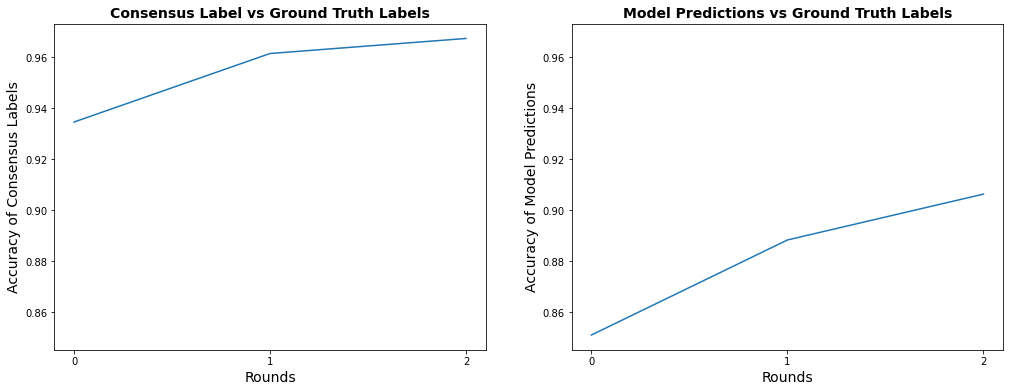

In [10]:
consensus_gtruth_accuracy = [model_results[i]["consensus_gtruth_accuracy"] 
                             for i in range(rounds)]

model_gtruth_accuracy = [model_results[i]["model_gtruth_accuracy"] for i in range(rounds)]


# plot prc
plt.rcParams["figure.figsize"] = (17,6)
plt.show()

ax1 = plt.subplot(1, 2, 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(range(0, rounds),consensus_gtruth_accuracy)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("Accuracy of Consensus Labels", fontsize=14)
plt.title("Consensus Label vs Ground Truth Labels", fontsize=14, fontweight="bold")

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.plot(range(0, rounds), model_gtruth_accuracy)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("Accuracy of Model Predictions", fontsize=14)
plt.title("Model Predictions vs Ground Truth Labels", fontsize=14, fontweight="bold")

plt.show()

### References 
Peterson, J., Battleday, R., Griffiths, T., & Russakovsky, O. (2019).
    **Human uncertainty makes classification more robust**.
    In *Proceedings of the IEEE International Conference on Computer Vision*.

In [ ]:
# You can ignore this cell, it is just used during CI.
# if consensus_gtruth_accuracy[0] >= consensus_gtruth_accuracy[-1]:  # check cleanlab has improved prediction accuracy
#     raise Exception("Cleanlab failed to improve baseline consensus label accuracy.")